In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [35]:
def groupby_Date_Hr(df,delta):
    
    df['time_gmt_datetime'] = pd.Series(index=df.index)
    
    for i in range(df.shape[0]):
        x = df['time_gmt_date'].iloc[i]
        x = datetime.strptime(x,"%Y-%m-%d")
        x = x+timedelta(hours=df['time_gmt_hr'].iloc[i])
        df['time_gmt_datetime'].iloc[i] = x
    
    dates = list(set(df['time_gmt_datetime'].to_list()))
    
    rows = []
    
    for dt in dates:
        
        dt_ = dt-timedelta(hours=delta)
        df_datetime = df.loc[(df['time_gmt_datetime'] > dt_) & (df['time_gmt_datetime'] <= dt)]
        
        text = ""
        for i in range(df_datetime.shape[0]):
            text = text+" "+df_datetime['title'].iloc[i]
            
        rows.append([dt, text])
    
    df_ = pd.DataFrame(rows)
    df_.columns=["time_gmt_date_hr","combined_text"]
    df_.sort_values(by='time_gmt_date_hr', ascending=True, inplace=True)
    
    return df_

def encode_price_direction(df):
    
    for i in range(df.shape[0]):
        
        val = df['price_direction'].iloc[i]
        
        if val == 'up':
            df['price_direction'].iloc[i] = 1
        else: 
            df['price_direction'].iloc[i] = 0
            
    return df

def align_datetime(df, delta):
    
    for i in range(df.shape[0]):
        x = df['date'].iloc[i]
        x = datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
        x = x-timedelta(hours=delta) 
        df['date'].iloc[i] = x
    
    df.rename(columns={"date": "time_gmt_date_hr"}, inplace=True)

    return df

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

def plotLossCurve(estimator):
    # Plot model loss over epochs
    plt.plot(estimator.history['loss'])
    plt.plot(estimator.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
def mlp_pretrained_glove_embedding(X_train,X_test,y_train,y_test,epochs):
    
    embeddings_index = {}
    f = open('Model/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    vocab_size = 5000
    oov_token = "<OOV>"
    max_length = 100
    padding_type = "post"
    trunction_type="post"

    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)
    
    word_index = tokenizer.word_index
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    
    X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)
    
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)
    
    embedding_matrix = np.zeros((len(word_index) + 1, max_length))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                max_length,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    estimator = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, verbose=1)

    plotLossCurve(estimator)

    loss, auc = model.evaluate(X_test_padded,y_test)
    print('Test AUC is {} '.format(auc))
    
def lstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs):

    embeddings_index = {}
    f = open('Model/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    vocab_size = 5000
    oov_token = "<OOV>"
    max_length = 100
    padding_type = "post"
    trunction_type="post"

    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)
    
    word_index = tokenizer.word_index
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    
    X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)
    
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)
    
    embedding_matrix = np.zeros((len(word_index) + 1, max_length))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,)

    embedding_dim = 16
    input_length = 100

    embedding_layer = Embedding(len(word_index) + 1,
                                max_length,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)

    model = Sequential([
      embedding_layer,
      LSTM(embedding_dim,),
      Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    estimator = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, verbose=1, callbacks=[early_stopping])

    plotLossCurve(estimator)

    loss, auc = model.evaluate(X_test_padded,y_test)
    print('Test AUC is {} '.format(auc))

    
def bilstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs):

    embeddings_index = {}
    f = open('Model/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    vocab_size = 5000
    oov_token = "<OOV>"
    max_length = 100
    padding_type = "post"
    trunction_type="post"

    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)
    
    word_index = tokenizer.word_index
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    
    X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)
    
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)
    
    embedding_matrix = np.zeros((len(word_index) + 1, max_length))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,)

    embedding_dim = 16
    input_length = 100

    embedding_layer = Embedding(len(word_index) + 1,
                                max_length,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)

    model = Sequential([
      embedding_layer,
      Bidirectional(LSTM(embedding_dim,)),
      Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    estimator = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, verbose=1, callbacks=[early_stopping])

    plotLossCurve(estimator)

    loss, auc = model.evaluate(X_test_padded,y_test)
    print('Test AUC is {} '.format(auc))

# Delta = 1 Hr

In [5]:
df_news = pd.read_csv('Data/news_data.csv')
df_combined_news = groupby_Date_Hr(df_news, delta=1)
df_combined_news.head(5)

<ipython-input-2-a3b996bdb93f>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['time_gmt_datetime'] = pd.Series(index=df.index)
/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time_gmt_date_hr,combined_text
6451,2015-12-28 00:00:00,japan output retail sales slump dampen recove...
3743,2015-12-28 04:00:00,japan business lobby head won t commit to hig...
556,2015-12-28 07:00:00,south korea japan agree to irreversibly end c...
3793,2015-12-28 08:00:00,japan firms cold on abe s calls for wage hike...
554,2015-12-28 10:00:00,for japan and south korea comfort women bronz...


In [6]:
df_usdjpy = pd.read_csv('Data/usdjpy_hourly.csv')
df_usdjpy = encode_price_direction(df_usdjpy)
df_usdjpy.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,price,price_direction
0,2016-01-01 00:00:00,120.2665,1
1,2016-01-01 01:00:00,120.2665,1
2,2016-01-01 02:00:00,120.2665,1
3,2016-01-01 03:00:00,120.2665,1
4,2016-01-01 04:00:00,120.2665,1


In [7]:
df_usdjpy_ = align_datetime(df_usdjpy, delta = 1)
df_usdjpy_.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time_gmt_date_hr,price,price_direction
0,2015-12-31 23:00:00,120.2665,1
1,2016-01-01 00:00:00,120.2665,1
2,2016-01-01 01:00:00,120.2665,1
3,2016-01-01 02:00:00,120.2665,1
4,2016-01-01 03:00:00,120.2665,1


In [8]:
df_combined_news['time_gmt_date_hr'] = pd.to_datetime(df_combined_news['time_gmt_date_hr'])
df_usdjpy_['time_gmt_date_hr'] = pd.to_datetime(df_usdjpy_['time_gmt_date_hr'])
df_merged = df_combined_news.merge(df_usdjpy_, on =['time_gmt_date_hr'])
df_merged.head()

,time_gmt_date_hr,combined_text,price,price_direction
0,2016-01-01 20:00:00,airbus to sell three a380 superjumbo jets to ...,120.2665,1
1,2016-01-01 21:00:00,airbus to sell three a380 superjumbo jets to ...,120.2665,1
2,2016-01-03 21:00:00,japan central bank turns activist investor to...,114.0480,1
3,2016-01-05 18:00:00,automakers not silicon valley lead in driverl...,106.3350,1
4,2016-01-06 04:00:00,japan says to make firm response to north kor...,109.9575,0


In [9]:
df_merged.shape

(6357, 4)

In [10]:
X = df_merged['combined_text']
y = df_merged[['price_direction']]

X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

Epoch 1/20
128/128 [==============================] - 33s 25ms/step - loss: 0.6929 - auc: 0.5061 - val_loss: 0.6897 - val_auc: 0.5077
Epoch 2/20
128/128 [==============================] - 0s 4ms/step - loss: 0.6443 - auc: 0.6435 - val_loss: 0.6928 - val_auc: 0.5161
Epoch 3/20
128/128 [==============================] - 0s 3ms/step - loss: 0.6158 - auc: 0.7086 - val_loss: 0.7034 - val_auc: 0.5142
Epoch 4/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5959 - auc: 0.7412 - val_loss: 0.7085 - val_auc: 0.5145
Epoch 5/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5825 - auc: 0.7550 - val_loss: 0.7280 - val_auc: 0.5122
Epoch 6/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5686 - auc: 0.7742 - val_loss: 0.7276 - val_auc: 0.5080
Epoch 7/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5573 - auc: 0.7861 - val_loss: 0.7373 - val_auc: 0.5079
Epoch 8/20
128/128 [==============================] - 1s 5ms/step - loss: 

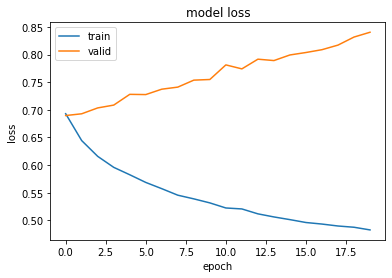

40/40 [==============================] - 0s 3ms/step - loss: 0.8652 - auc: 0.4724
Test AUC is 0.47244590520858765 


In [12]:
epochs = 20
mlp_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/100
128/128 [==============================] - 9s 50ms/step - loss: 0.6807 - auc: 0.5048 - val_loss: 0.6819 - val_auc: 0.4957
Epoch 2/100
128/128 [==============================] - 5s 41ms/step - loss: 0.6795 - auc: 0.4995 - val_loss: 0.6804 - val_auc: 0.4996
Epoch 3/100
128/128 [==============================] - 5s 41ms/step - loss: 0.6794 - auc: 0.5008 - val_loss: 0.6804 - val_auc: 0.5003
Epoch 4/100
128/128 [==============================] - 6s 44ms/step - loss: 0.6790 - auc: 0.4955 - val_loss: 0.6806 - val_auc: 0.5000
Epoch 5/100
128/128 [==============================] - 5s 41ms/step - loss: 0.6794 - auc: 0.4931 - val_loss: 0.6804 - val_auc: 0.5003
Epoch 6/100
128/128 [==============================] - 5s 41ms/step - loss: 0.6795 - auc: 0.4946 - val_loss: 0.6803 - val_auc: 0.5000
Epoch 7/100
128/128 [==============================] - 5s 42ms/step - loss: 0.6792 - auc: 0.4931 - val_loss: 0.6804 - val_auc: 0.5000
Epoch 8/100
128/128 [==============================] - 5s 40ms

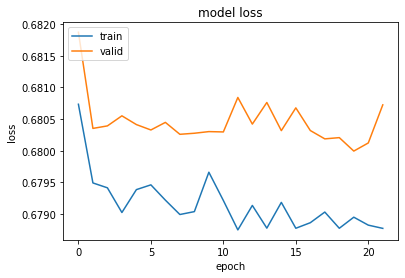

40/40 [==============================] - 0s 11ms/step - loss: 0.6797 - auc: 0.5025
Test AUC is 0.5025109052658081 


In [15]:
epochs = 100
lstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/50
128/128 [==============================] - 12s 61ms/step - loss: 0.6813 - auc: 0.5067 - val_loss: 0.6817 - val_auc: 0.5168
Epoch 2/50
128/128 [==============================] - 7s 54ms/step - loss: 0.6773 - auc: 0.5371 - val_loss: 0.6806 - val_auc: 0.5198
Epoch 3/50
128/128 [==============================] - 7s 54ms/step - loss: 0.6746 - auc: 0.5545 - val_loss: 0.6809 - val_auc: 0.5253
Epoch 4/50
128/128 [==============================] - 7s 54ms/step - loss: 0.6717 - auc: 0.5714 - val_loss: 0.6823 - val_auc: 0.5163
Epoch 5/50
128/128 [==============================] - 7s 51ms/step - loss: 0.6688 - auc: 0.5831 - val_loss: 0.6834 - val_auc: 0.5187
Epoch 6/50
128/128 [==============================] - 7s 53ms/step - loss: 0.6646 - auc: 0.5977 - val_loss: 0.6859 - val_auc: 0.5074
Epoch 7/50
128/128 [==============================] - 7s 55ms/step - loss: 0.6604 - auc: 0.6136 - val_loss: 0.6874 - val_auc: 0.5122
Epoch 8/50
128/128 [==============================] - 7s 54ms/step -

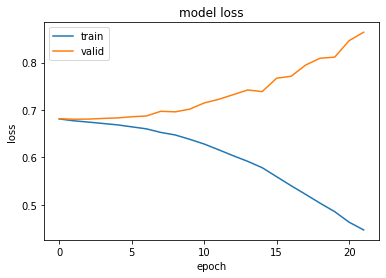

40/40 [==============================] - 1s 15ms/step - loss: 0.6808 - auc: 0.4999
Test AUC is 0.4999225437641144 


In [16]:
epochs = 50
bilstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

# Delta = 2 Hr

In [36]:
df_news = pd.read_csv('Data/news_data.csv')
df_combined_news = groupby_Date_Hr(df_news, 2)
df_combined_news.head(5)

<ipython-input-35-03c321cc2c8b>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['time_gmt_datetime'] = pd.Series(index=df.index)


,time_gmt_date_hr,combined_text
6451,2015-12-28 00:00:00,japan output retail sales slump dampen recove...
3743,2015-12-28 04:00:00,japan business lobby head won t commit to hig...
556,2015-12-28 07:00:00,south korea japan agree to irreversibly end c...
3793,2015-12-28 08:00:00,south korea japan agree to irreversibly end c...
554,2015-12-28 10:00:00,for japan and south korea comfort women bronz...


In [37]:
df_usdjpy = pd.read_csv('Data/usdjpy_hourly.csv')
df_usdjpy = encode_price_direction(df_usdjpy)
df_usdjpy.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,price,price_direction
0,2016-01-01 00:00:00,120.2665,1
1,2016-01-01 01:00:00,120.2665,1
2,2016-01-01 02:00:00,120.2665,1
3,2016-01-01 03:00:00,120.2665,1
4,2016-01-01 04:00:00,120.2665,1


In [38]:
df_usdjpy_ = align_datetime(df_usdjpy, delta = 2)
df_usdjpy_.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time_gmt_date_hr,price,price_direction
0,2015-12-31 22:00:00,120.2665,1
1,2015-12-31 23:00:00,120.2665,1
2,2016-01-01 00:00:00,120.2665,1
3,2016-01-01 01:00:00,120.2665,1
4,2016-01-01 02:00:00,120.2665,1


In [39]:
df_combined_news['time_gmt_date_hr'] = pd.to_datetime(df_combined_news['time_gmt_date_hr'])
df_usdjpy_['time_gmt_date_hr'] = pd.to_datetime(df_usdjpy_['time_gmt_date_hr'])
df_merged = df_combined_news.merge(df_usdjpy_, on =['time_gmt_date_hr'])
df_merged.head()

,time_gmt_date_hr,combined_text,price,price_direction
0,2016-01-01 20:00:00,airbus to sell three a380 superjumbo jets to ...,120.2665,1
1,2016-01-01 21:00:00,airbus to sell three a380 superjumbo jets to ...,120.2665,1
2,2016-01-03 21:00:00,japan central bank turns activist investor to...,113.9180,0
3,2016-01-05 18:00:00,automakers not silicon valley lead in driverl...,106.3350,1
4,2016-01-06 04:00:00,japan says to make firm response to north kor...,110.0615,1


In [40]:
X = df_merged['combined_text']
y = df_merged[['price_direction']]

X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

Epoch 1/20
128/128 [==============================] - 2s 6ms/step - loss: 0.6989 - auc: 0.5030 - val_loss: 0.6849 - val_auc: 0.5276
Epoch 2/20
128/128 [==============================] - 0s 3ms/step - loss: 0.6342 - auc: 0.6616 - val_loss: 0.6934 - val_auc: 0.5266
Epoch 3/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5996 - auc: 0.7261 - val_loss: 0.7056 - val_auc: 0.5195
Epoch 4/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5786 - auc: 0.7529 - val_loss: 0.7194 - val_auc: 0.5179
Epoch 5/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5546 - auc: 0.7878 - val_loss: 0.7260 - val_auc: 0.5149
Epoch 6/20
128/128 [==============================] - 0s 4ms/step - loss: 0.5402 - auc: 0.8014 - val_loss: 0.7409 - val_auc: 0.5142
Epoch 7/20
128/128 [==============================] - 0s 2ms/step - loss: 0.5258 - auc: 0.8191 - val_loss: 0.7522 - val_auc: 0.5132
Epoch 8/20
128/128 [==============================] - 0s 3ms/step - loss: 0.

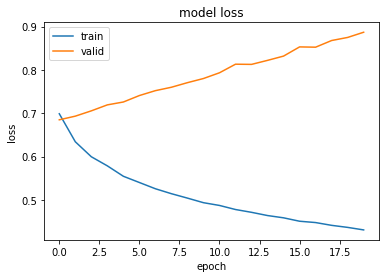

40/40 [==============================] - 0s 1ms/step - loss: 0.9046 - auc: 0.4606
Test AUC is 0.4606453776359558 


In [41]:
epochs = 20
mlp_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/100
128/128 [==============================] - 10s 52ms/step - loss: 0.6791 - auc: 0.5002 - val_loss: 0.6783 - val_auc: 0.4996
Epoch 2/100
128/128 [==============================] - 5s 42ms/step - loss: 0.6766 - auc: 0.5057 - val_loss: 0.6795 - val_auc: 0.4996
Epoch 3/100
128/128 [==============================] - 5s 43ms/step - loss: 0.6770 - auc: 0.4913 - val_loss: 0.6783 - val_auc: 0.4988
Epoch 4/100
128/128 [==============================] - 6s 44ms/step - loss: 0.6763 - auc: 0.4991 - val_loss: 0.6801 - val_auc: 0.4996
Epoch 5/100
128/128 [==============================] - 6s 46ms/step - loss: 0.6768 - auc: 0.4884 - val_loss: 0.6787 - val_auc: 0.4996
Epoch 6/100
128/128 [==============================] - 6s 43ms/step - loss: 0.6764 - auc: 0.4908 - val_loss: 0.6783 - val_auc: 0.4985
Epoch 7/100
128/128 [==============================] - 6s 43ms/step - loss: 0.6765 - auc: 0.4939 - val_loss: 0.6784 - val_auc: 0.4997
Epoch 8/100
128/128 [==============================] - 6s 48m

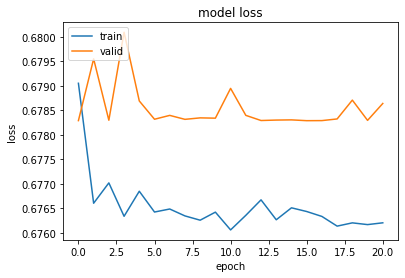

40/40 [==============================] - 0s 11ms/step - loss: 0.6731 - auc: 0.5023
Test AUC is 0.5022854804992676 


In [43]:
epochs = 100
lstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/50
128/128 [==============================] - 15s 76ms/step - loss: 0.6799 - auc: 0.4909 - val_loss: 0.6797 - val_auc: 0.5007
Epoch 2/50
128/128 [==============================] - 8s 59ms/step - loss: 0.6749 - auc: 0.5312 - val_loss: 0.6812 - val_auc: 0.5045
Epoch 3/50
128/128 [==============================] - 9s 71ms/step - loss: 0.6721 - auc: 0.5524 - val_loss: 0.6809 - val_auc: 0.5095
Epoch 4/50
128/128 [==============================] - 8s 61ms/step - loss: 0.6689 - auc: 0.5697 - val_loss: 0.6806 - val_auc: 0.5113
Epoch 5/50
128/128 [==============================] - 8s 62ms/step - loss: 0.6663 - auc: 0.5817 - val_loss: 0.6825 - val_auc: 0.5187
Epoch 6/50
128/128 [==============================] - 8s 64ms/step - loss: 0.6623 - auc: 0.5975 - val_loss: 0.6820 - val_auc: 0.5224
Epoch 7/50
128/128 [==============================] - 8s 60ms/step - loss: 0.6567 - auc: 0.6154 - val_loss: 0.6843 - val_auc: 0.5227
Epoch 8/50
128/128 [==============================] - 8s 63ms/step -

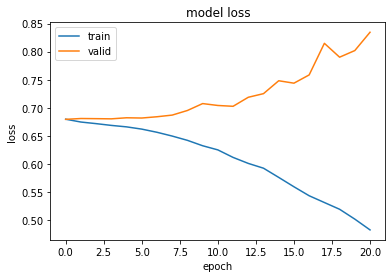

40/40 [==============================] - 1s 13ms/step - loss: 0.6749 - auc: 0.5047
Test AUC is 0.5046713352203369 


In [44]:
epochs = 50
bilstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

# Delta = 5 hrs

In [45]:
df_news = pd.read_csv('Data/news_data.csv')
df_combined_news = groupby_Date_Hr(df_news, 5)
df_combined_news.head(5)

<ipython-input-35-03c321cc2c8b>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['time_gmt_datetime'] = pd.Series(index=df.index)
/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time_gmt_date_hr,combined_text
6451,2015-12-28 00:00:00,japan output retail sales slump dampen recove...
3743,2015-12-28 04:00:00,japan business lobby head won t commit to hig...
556,2015-12-28 07:00:00,south korea japan agree to irreversibly end c...
3793,2015-12-28 08:00:00,south korea japan agree to irreversibly end c...
554,2015-12-28 10:00:00,south korea japan agree to irreversibly end c...


In [46]:
df_usdjpy = pd.read_csv('Data/usdjpy_hourly.csv')
df_usdjpy = encode_price_direction(df_usdjpy)
df_usdjpy.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,price,price_direction
0,2016-01-01 00:00:00,120.2665,1
1,2016-01-01 01:00:00,120.2665,1
2,2016-01-01 02:00:00,120.2665,1
3,2016-01-01 03:00:00,120.2665,1
4,2016-01-01 04:00:00,120.2665,1


In [47]:
df_usdjpy_ = align_datetime(df_usdjpy, delta = 5)
df_usdjpy_.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,time_gmt_date_hr,price,price_direction
0,2015-12-31 19:00:00,120.2665,1
1,2015-12-31 20:00:00,120.2665,1
2,2015-12-31 21:00:00,120.2665,1
3,2015-12-31 22:00:00,120.2665,1
4,2015-12-31 23:00:00,120.2665,1


In [48]:
df_combined_news['time_gmt_date_hr'] = pd.to_datetime(df_combined_news['time_gmt_date_hr'])
df_usdjpy_['time_gmt_date_hr'] = pd.to_datetime(df_usdjpy_['time_gmt_date_hr'])
df_merged = df_combined_news.merge(df_usdjpy_, on =['time_gmt_date_hr'])
df_merged.head()

,time_gmt_date_hr,combined_text,price,price_direction
0,2016-01-01 20:00:00,airbus to sell three a380 superjumbo jets to ...,121.2785,1
1,2016-01-01 21:00:00,airbus to sell three a380 superjumbo jets to ...,121.2760,0
2,2016-01-03 21:00:00,japan central bank turns activist investor to...,112.2090,1
3,2016-01-05 18:00:00,automakers not silicon valley lead in driverl...,106.4375,0
4,2016-01-06 04:00:00,japan says to make firm response to north kor...,109.6410,0


In [49]:
X = df_merged['combined_text']
y = df_merged[['price_direction']]

X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

Epoch 1/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6991 - auc: 0.5040 - val_loss: 0.7059 - val_auc: 0.5373
Epoch 2/20
128/128 [==============================] - 0s 2ms/step - loss: 0.5952 - auc: 0.7135 - val_loss: 0.7206 - val_auc: 0.5277
Epoch 3/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5514 - auc: 0.7799 - val_loss: 0.7618 - val_auc: 0.5299
Epoch 4/20
128/128 [==============================] - 0s 3ms/step - loss: 0.5136 - auc: 0.8230 - val_loss: 0.7350 - val_auc: 0.5349
Epoch 5/20
128/128 [==============================] - 0s 2ms/step - loss: 0.4873 - auc: 0.8519 - val_loss: 0.7972 - val_auc: 0.5253
Epoch 6/20
128/128 [==============================] - 0s 2ms/step - loss: 0.4647 - auc: 0.8707 - val_loss: 0.7690 - val_auc: 0.5388
Epoch 7/20
128/128 [==============================] - 0s 2ms/step - loss: 0.4462 - auc: 0.8839 - val_loss: 0.7897 - val_auc: 0.5371
Epoch 8/20
128/128 [==============================] - 0s 2ms/step - loss: 0.

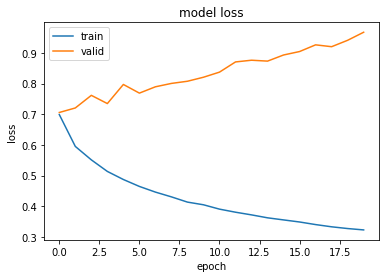

40/40 [==============================] - 0s 2ms/step - loss: 0.9756 - auc: 0.4991
Test AUC is 0.4990692734718323 


In [50]:
epochs = 20
mlp_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/100
128/128 [==============================] - 9s 47ms/step - loss: 0.6761 - auc: 0.4892 - val_loss: 0.6829 - val_auc: 0.5093
Epoch 2/100
128/128 [==============================] - 5s 40ms/step - loss: 0.6709 - auc: 0.4916 - val_loss: 0.6834 - val_auc: 0.5143
Epoch 3/100
128/128 [==============================] - 5s 39ms/step - loss: 0.6705 - auc: 0.4991 - val_loss: 0.6832 - val_auc: 0.5069
Epoch 4/100
128/128 [==============================] - 5s 39ms/step - loss: 0.6696 - auc: 0.4987 - val_loss: 0.6841 - val_auc: 0.5135
Epoch 5/100
128/128 [==============================] - 5s 38ms/step - loss: 0.6692 - auc: 0.5056 - val_loss: 0.6823 - val_auc: 0.5235
Epoch 6/100
128/128 [==============================] - 5s 41ms/step - loss: 0.6687 - auc: 0.5118 - val_loss: 0.6837 - val_auc: 0.5207
Epoch 7/100
128/128 [==============================] - 5s 40ms/step - loss: 0.6676 - auc: 0.5106 - val_loss: 0.6829 - val_auc: 0.5282
Epoch 8/100
128/128 [==============================] - 5s 41ms

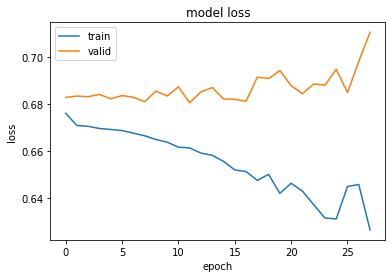

40/40 [==============================] - 0s 10ms/step - loss: 0.6732 - auc: 0.5198
Test AUC is 0.519814133644104 


In [51]:
epochs = 100
lstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/50
128/128 [==============================] - 12s 64ms/step - loss: 0.6713 - auc: 0.5178 - val_loss: 0.6856 - val_auc: 0.4994
Epoch 2/50
128/128 [==============================] - 6s 51ms/step - loss: 0.6663 - auc: 0.5549 - val_loss: 0.6881 - val_auc: 0.5050
Epoch 3/50
128/128 [==============================] - 6s 50ms/step - loss: 0.6624 - auc: 0.5760 - val_loss: 0.6890 - val_auc: 0.5097
Epoch 4/50
128/128 [==============================] - 6s 49ms/step - loss: 0.6582 - auc: 0.5960 - val_loss: 0.6967 - val_auc: 0.5160
Epoch 5/50
128/128 [==============================] - 6s 49ms/step - loss: 0.6534 - auc: 0.6105 - val_loss: 0.6889 - val_auc: 0.5165
Epoch 6/50
128/128 [==============================] - 6s 49ms/step - loss: 0.6473 - auc: 0.6298 - val_loss: 0.6897 - val_auc: 0.5171
Epoch 7/50
128/128 [==============================] - 6s 50ms/step - loss: 0.6381 - auc: 0.6514 - val_loss: 0.6976 - val_auc: 0.5266
Epoch 8/50
128/128 [==============================] - 7s 52ms/step -

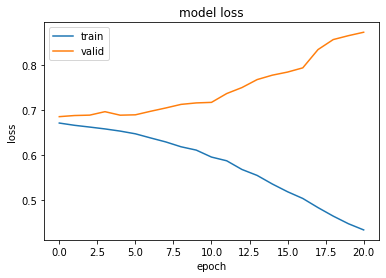

40/40 [==============================] - 1s 13ms/step - loss: 0.6722 - auc: 0.5172
Test AUC is 0.5171997547149658 


In [52]:
epochs = 50
bilstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)